# Azure OpenAI Service - Q&A with semantic answering exerise

In this tutorial, you'll build a simple Q&A system, that can give semantic answers to questions. Three sample documents from the Azure documentation are provided. Fill out the missing pieces in the source source to get everything working (indicated by `#FIXME`).

In [1]:
import os
import json
import tiktoken
import openai
import numpy as np
from dotenv import load_dotenv
from openai.embeddings_utils import cosine_similarity

# Load environment variables
load_dotenv()

# Configure Azure OpenAI Service API
openai.api_type = "azure"
openai.api_version = "2022-12-01"
openai.api_base = os.getenv('OPENAI_API_BASE')
openai.api_key = os.getenv("OPENAI_API_KEY")

# Define embedding model and encoding
EMBEDDING_MODEL = 'text-embedding-ada-002'
EMBEDDING_ENCODING = 'cl100k_base'
EMBEDDING_CHUNK_SIZE = 8000
COMPLETION_MODEL = 'text-davinci-003'

# initialize tiktoken for encoding text
encoding = tiktoken.get_encoding(EMBEDDING_ENCODING)

Next, let's read the documents in `/data/qna/*.txt`, which are our sample documents:

In [3]:
# list all files in the samples directory
samples_dir = os.path.join(os.getcwd(), "../data/qna/")
sample_files = os.listdir(samples_dir)

# read each file and remove and newlines (better for embeddings later)
documents = []
for file in sample_files:
    with open(os.path.join(samples_dir, file), "r") as f:
        content = f.read()
        content = content.replace("\n", " ")
        content = content.replace("  ", " ")
        documents.append(content)

# print some stats about the documents
print(f"Loaded {len(documents)} documents")
for doc in documents:
    num_tokens = len(encoding.encode(doc))
    print(f"Content: {doc[:80]}... \n---> Tokens: {num_tokens}\n")

Loaded 3 documents
Content:  # What is Azure OpenAI? The Azure OpenAI service provides REST API access to Op... 
---> Tokens: 1891

Content:  # What is Azure Cognitive Services Translator? Translator Service is a cloud-ba... 
---> Tokens: 739

Content:  # What is conversational language understanding? Conversational language unders... 
---> Tokens: 1341



Now that we have all documents loaded, we can embed them using our embedding model:

In [18]:

def get_embedding(text):
    return openai.Embedding.create(input=text, engine=EMBEDDING_MODEL)["data"][0]["embedding"]

result = openai.Embedding.create(input=documents, engine=EMBEDDING_MODEL)

In [28]:
result['object']
len(result['data'])
#result['model']
#result['usage']

3

In [29]:
len(documents)

3

In [30]:
# Create embeddings for all docs


def get_embedding(text):
    return openai.Embedding.create(input=text, engine=EMBEDDING_MODEL)["data"][0]["embedding"]

#embeddings = embeddings.embed_documents(documents)
embeddings = [get_embedding(doc) for doc in documents]

# print some stats about the embeddings
for e in embeddings:
    print(len(e))

1536
1536
1536


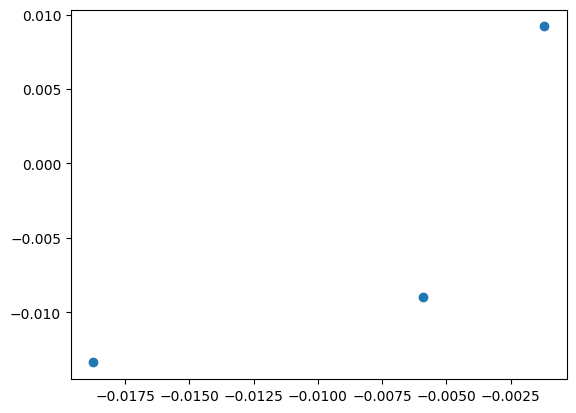

In [42]:
embeddings_np = np.asarray(embeddings)
embeddings_np[:, 0:2]

import matplotlib.pyplot as plt
plt.scatter(embeddings_np[:, 0], embeddings_np[:, 1])
plt.show()

Now that we have our embeddings, we can try to ask some questions and see if it retrieves the correct document. You can try the following questions:

* what is azure openai service?
* can translator be fine tuned?
* what is the difference between luis and clu?
* what is form recognizer? (should yield no result)

In [43]:
# create embedding for question
question = "what is azure openai service?"
qe = get_embedding(question)

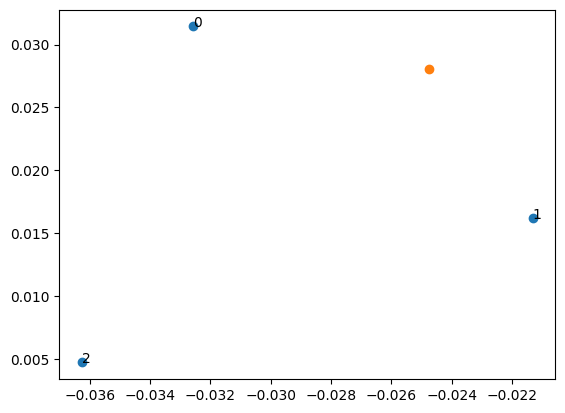

In [54]:
first_dim, second_dim = 9, 10


plt.scatter(embeddings_np[:, first_dim], embeddings_np[:, second_dim])
for i in range(embeddings_np.shape[0]):
    plt.text(embeddings_np[i,first_dim], embeddings_np[i,second_dim], str(i))
plt.scatter(np.asarray(qe)[first_dim], np.asarray(qe)[second_dim])
plt.show()


In [55]:


# calculate cosine similarity between question and each document
similaries = [cosine_similarity(a=qe, b=e) for e in embeddings]

# Get the matching document, in this case we just use argmax of similarities
max_i = np.argmax(similaries)

# print some stats about the similarities
for i, s in enumerate(similaries):
    print(f"Similarity to {sample_files[i]} is {s}")
print(f"Matching document is {sample_files[max_i]}")

Similarity to overview_openai.txt is 0.8674998947964985
Similarity to overview_translator.txt is 0.7914908142869009
Similarity to overview_clu.txt is 0.7739850962131803
Matching document is overview_openai.txt


In [57]:
# Generate a prompt that we use for completion, in this case we put the matched document and the question in the prompt
prompt = f"Answer below Question based on Document. Document: {documents[max_i]}; Question: {question}. Answer:"

# get response from completion model
response = openai.Completion.create(
    engine=COMPLETION_MODEL,
    prompt=prompt,
    temperature=0.7,
    max_tokens=500,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
    stop=None
)
answer = response['choices'][0]['text']

answer = response.choices[0].text

# print the question and answer
print(f"Question was: {question}\nRetrieved answer was: {answer}")

Question was: what is azure openai service?
Retrieved answer was:  Azure OpenAI Service is a new product offering on Azure providing customers advanced language AI with OpenAI GPT-3, Codex, and DALL-E models with the security and enterprise promise of Azure. It co-develops the APIs with OpenAI, ensures compatibility and a smooth transition from one to the other. With Azure OpenAI, customers get the security capabilities of Microsoft Azure while running the same models as OpenAI. Azure OpenAI offers private networking, regional availability, and responsible AI content filtering.


Great, that worked. Now we should have a simple understanding how Q&A can work using Azure OpenAI Service embeddings and completions. Next step would be:

* Chunking of longer documents (you might run into token limits for embeddings and the answering prompt)
* Usage of a vector database (pinecone, redis, etc.) to scale the search part to a larger amount of documents
* Evaluation of the top k results, instead of just the best matching document
* ...and a few more!